# Foundations of Data Mining: Assignment 1

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [1]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100
InteractiveShell.ast_node_interactivity = "all"

DEBUG = False

import itertools
import math
import random
from collections import defaultdict

import graphviz
import pandas as pd
from scipy.stats import distributions
from sklearn import ensemble
from sklearn.ensemble import (RandomForestClassifier,
                              RandomForestRegressor,
                              GradientBoostingRegressor)
from sklearn.linear_model import (LogisticRegression, Lasso,
                                  Ridge, LinearRegression)
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     ShuffleSplit, StratifiedKFold,
                                     cross_val_score, train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## Handwritten digit recognition (5 points, 1+2+2)
The [MNIST dataset](https://www.openml.org/d/554) contains 70,000 images of handwritten digits (0-9) represented by 28 by 28 pixel values. We can easily download it from OpenML and visualize one of the examples:

Class label: 5


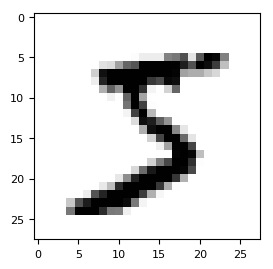

In [2]:
# Download MNIST data
mnist_data = oml.datasets.get_dataset(554)

# Get the predictors X and the labels y
X, y = mnist_data.get_data(target=mnist_data.default_target_attribute);

# Take the first example, reshape to a 28x28 image and plot
plt.imshow(X[0].reshape(28, 28), cmap=plt.cm.gray_r)

# Print the correct class label
print("Class label:",y[0])

- Evaluate a k-Nearest Neighbor classifier with its default settings.
    - Use the first 60,000 examples as the training set and the last 10,000 as the test set
    - What is the predictive accuracy?
    - Find a few misclassifications, and plot them together with the true labels (as above). Are these images really hard to classify?
- Optimize the value for the number of neighbors $k$ (keep $k$ < 50) on a stratified subsample (e.g. 10%) of the data
    - Use 10-fold crossvalidation and plot $k$ against the misclassification rate. Which value of $k$ should you pick?
    - Do the same but with 100 bootstrapping repeats. Are the results different? Explain.
- Compare kNN against the linear classification models that we have covered in the course (logistic regression and linear SVMs).
    - First use the default hyperparameter settings.
    - Next, optimize for the degree of regularization ($C$) and choice of penalty (L1/L2). Again, plot the accuracy while increasing the degree of regularization for different penalties. Interpret the results. 
    - Report is the optimal performance. Can you get better results than kNN?
    
Report all results clearly and interpret the results.  
Note: while prototyping/bugfixing, you can speed up experiments by taking a smaller sample of the data, but report your results as indicated above.

### Solution

Predictive accuracy is 0.9688


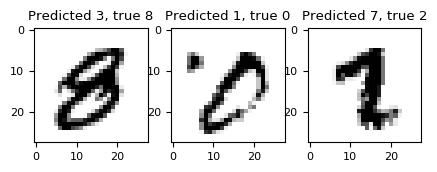

In [3]:
if DEBUG:
    print('*** DEBUG RUN ***')
    Xtrain, ytrain, Xtest, ytest = \
        X[:600], y[:600], X[600:700], y[600:700]
else:
    Xtrain, ytrain, Xtest, ytest = \
        X[:60000], y[:60000], X[60000:], y[60000:]

knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(Xtrain, ytrain);
ypred = knn.predict(Xtest);

print("Predictive accuracy is {}".format(
    accuracy_score(ytest, ypred)
))

mask_wrong = ytest != ypred
wrong, pred_wrong, y_wrong = \
    Xtest[mask_wrong], ypred[mask_wrong], ytest[mask_wrong]
for col in range(3):
    d = random.randint(0, wrong.shape[0] - 1)

    plt.subplot(1, 3, col + 1);
    plt.title("Predicted {}, true {}".format(
        pred_wrong[d], y_wrong[d])
    );
    plt.imshow(wrong[d].reshape(28, 28),
               cmap=plt.cm.gray_r);

plt.show();

The predictive accuracy is 0.9688, and most of the mis-classified images are actually easy to recognize.

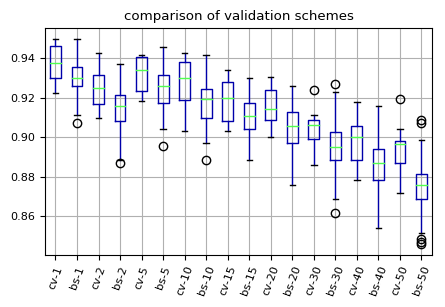

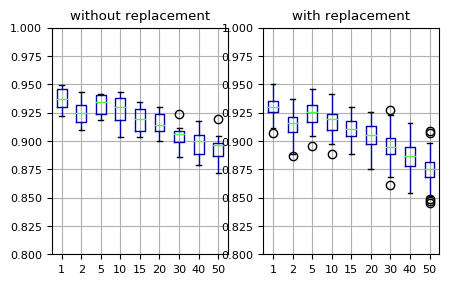

In [4]:
if DEBUG:
    print('*** DEBUG RUN ***')

size = 0.005 if DEBUG else 0.1
x_sample, _, y_sample, _ = train_test_split(
    X, y, train_size=size, stratify=y
)

scores = []
ks = [1, 2, 5, 10, 15, 20, 30, 40, 50]
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores.append(cross_val_score(
        knn, x_sample, y_sample, n_jobs=-1, cv=10
    ))
    
    knn = KNeighborsClassifier(n_neighbors=k)
    scores.append(cross_val_score(
        knn, x_sample, y_sample, n_jobs=-1, 
        cv=ShuffleSplit(100, train_size=0.66)
    ))
    print("finished k={}".format(k), ' ' * 10, end='\r')
print(' ' * 100)

plt.title('comparison of validation schemes');
idx = list(itertools.chain(*[
    ['cv-' + str(k), 'bs-' + str(k)] for k in ks
]));
axs = pd.DataFrame(scores, index=idx).transpose().boxplot();
plt.setp(axs.xaxis.get_majorticklabels(), rotation=70);
plt.show();

plt.subplot(1, 2, 1);
plt.ylim((0.8, 1.0));
plt.title('without replacement');
pd.DataFrame(scores[::2], index=ks).transpose().boxplot();

plt.subplot(1, 2, 2);
plt.ylim((0.8, 1.0));
plt.title('with replacement');
pd.DataFrame(scores[1::2], index=ks).transpose().boxplot();
plt.show();

According to the 10-fold cross-validation results, the best number of neighbors to consider is either 1 or 5; they perform very similarly, and the slight differences shown in the plots may well be due to randomness in the folds. The best value to pick is 5, because the resulting smoothing would give more accurate predictions when classifying ambiguous digits (especially those digits that are very different from any image in the dataset).

Cross-validation using sampling with and without replacement give similar results that strongly agree in the overall trend, but scores obtained via cross-validation are on average higher than the respective scores obtained via bootstrapping using the same $k$. This is expected, because the former used 90% for training, while the latter only 66%.

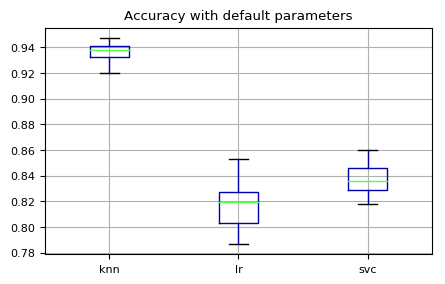

In [6]:
if DEBUG:
    print('*** DEBUG RUN ***')
    
size = 0.005 if DEBUG else 0.1
Xtrain, _, ytrain, _ = train_test_split(X, y, train_size=size,
                                        stratify=y)

scores_knn = cross_val_score(KNeighborsClassifier(), Xtrain,
                             ytrain, n_jobs=-1, cv=10)
scores_lr = cross_val_score(LogisticRegression(), Xtrain,
                            ytrain, n_jobs=-1, cv=10)
scores_svc = cross_val_score(LinearSVC(), Xtrain,
                             ytrain, n_jobs=-1, cv=10)

plt.title('Accuracy with default parameters')
pd.DataFrame(
    [scores_knn, scores_lr, scores_svc],
    index=['knn', 'lr', 'svc']
).transpose().boxplot();

Using the default parameters, k-nearest neighbors is by far the best model.

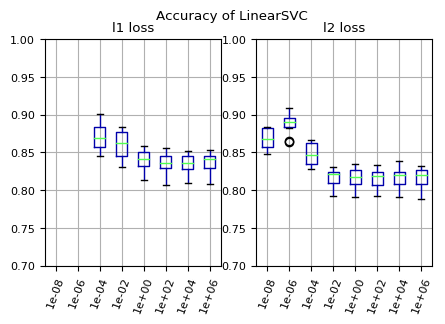

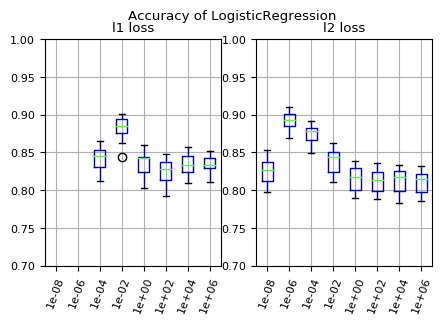

In [7]:
if DEBUG:
    print('*** DEBUG RUN ***')

size = 0.005 if DEBUG else 0.1
Xtrain, _, ytrain, _ = train_test_split(X, y, train_size=size,
                                        stratify=y)

def optimize_model(model_factory, cv=10):
    cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 1e2, 1e4, 1e6]
    scores = []
    for loss in ['l1', 'l2']:
        for c in cs:
            model = model_factory(loss, c)
            scores.append(list(cross_val_score(
                model, Xtrain, ytrain, n_jobs=-1, cv=cv
            )))
            print('finished', loss, c, ' ' * 50, end='\r')
    print(' ' * 100)
    
    def plot(scores):
        plt.ylim((0.7, 1.0))
        
        axs = pd.DataFrame(
            scores, index=map('{:.0e}'.format, cs)
        ).transpose().boxplot()
        
        plt.setp(axs.xaxis.get_majorticklabels(),
                 rotation=70)
    
    plt.suptitle("Accuracy of {}".format(
        model.__class__.__name__, cv
    ))
    
    plt.subplot(1, 2, 1)
    plt.title('l1 loss')
    plot(scores[:len(cs)])
    
    plt.subplot(1, 2, 2)
    plt.title('l2 loss')
    plot(scores[len(cs):])
    
    plt.show()

optimize_model(lambda loss, c: LinearSVC(
    penalty=loss, C=c, dual=False
))

optimize_model(lambda loss, c: LogisticRegression(
    penalty=loss, C=c
))

Both with logistic regression and the linear SVC it is possible to achieve accuracies close to 0.9, but k-nearest neighbors is the best classification model as its accuracy is around 0.94. This means that the separation surface between the digits is almost, but not exactly linear, because linear models have, all in all, good performance, but a simple non-linear model is better.

With such small $C$ values, misclassifications are heavily penalized, thus the SVM produces a plane with a small margin, and uses few support vectors. This is consistent with the results obtained when optimizing $k$ for k-nearest neighbors, and it means that there is overlap and ambiguity among the samples in the dataset, and that the separation surface between them is almost, but not exactly, linear.

The choice of the loss does not significantly affect the maximum achievable performance, but it does influence the amount of regularization needed to reach it; L2 loss performs best with higher regularization than L1 loss.

## Model selection (4 points (2+2))
Study how RandomForest hyperparameters interact on the Ionosphere dataset (OpenML ID 59).

- Optimize a RandomForest, varying both $n\_estimators$ and $max\_features$ at the same time. Use a nested cross-validation and a grid search (or random search) over the possible values, and measure the AUC. Explore how fine-grained this grid/random search can be, given your computational resources. What is the optimal AUC performance you find?
- Again, vary both hyperparameters, but this time use a grid search and visualize the results as a plot (heatmap) $n\_estimators \times max\_features \rightarrow AUC$ with AUC visualized as the color of the data point. Try to make the grid as fine as possible. Interpret the results. Can you explain your observations? What did you learn about tuning RandomForests?

Hint: Running this experiment can take a while, so start early and use a feasible grid/random search. Start with a coarse grid or few random search iterations.
Hint: Use a log scale (1,2,4,8,16,...) for $n\_estimators$. Vary $max\_features$ linearly between 1 and the total number of features. Note that, if you give $max\_features$ a float value, it will use it as [the percentage of the total number of features](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).


### Solution

In [8]:
# Download Ionosphere data
ionosphere = oml.datasets.get_dataset(59)

# Get the predictors X and the labels y
X, y = ionosphere.get_data(target=ionosphere.default_target_attribute);

In [9]:
if DEBUG:
    print('*** DEBUG RUN ***')
    
gs = RandomizedSearchCV(RandomForestClassifier(), param_distributions={
    'n_estimators': distributions.randint(1, 1000),
    'max_features': distributions.uniform(0, 1)
}, n_iter=(10 if DEBUG else 100), n_jobs=-1, cv=10, scoring='roc_auc');

scores = cross_val_score(gs, X, y, cv=10)
print("Mean nested cross-validation score is {}, maximum is {}".format(
    scores.mean(), scores.max()
))

Mean nested cross-validation score is 0.9760242474916387, maximum is 1.0


Best AUC is 0.9806570550717709, obtained with
	n_estimators = 512
	max_features = 0.2


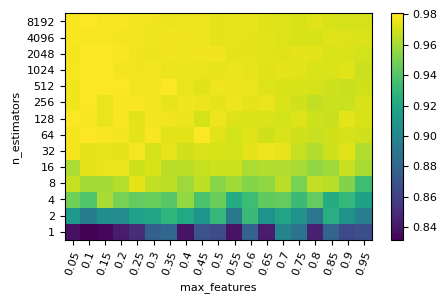

In [10]:
if DEBUG:
    print('*** DEBUG RUN ***')

param_grid={
    'n_estimators': [1, 50, 100],
    'max_features': [0.1, 0.5, 0.9],
} if DEBUG else {
    'n_estimators': [2**x for x in range(14)],
    'max_features': np.arange(0.05, 1.0, 0.05),
}

gs = GridSearchCV(RandomForestClassifier(), param_grid=param_grid,
                  cv=10, n_jobs=-1, scoring='roc_auc');
gs.fit(X, y);

print('Best AUC is {}, obtained with\n\tn_estimators = {}'
      '\n\tmax_features = {}'.format(
          
    gs.best_score_, gs.best_params_['n_estimators'],
    gs.best_params_['max_features']
));

scores = np.array(gs.cv_results_['mean_test_score']).reshape(
    len(param_grid['max_features']),
    len(param_grid['n_estimators'])
).T;

img = mglearn.tools.heatmap(
    scores, cmap='viridis', fmt='',
    ylabel='n_estimators', yticklabels=param_grid['n_estimators'],
    xlabel='max_features', xticklabels=param_grid['max_features'],
);

plt.colorbar(img);
plt.setp(img.get_axes().xaxis.get_majorticklabels(),
         rotation=70);
plt.show();

The best models are build by using few features for each tree, and a lot of trees. An explanation for this is that, when the trees are build with few features, they are able to accurately model them, so the forest will be composed by a lot of trees that are very accurate on a particular subset of features. On the other hand, training trees on a lot of features forces them to be more general, thus their classification performances suffer.

The number of features marginally affects the performances, and the best way to improve them is to increase the number of trees. The averaging prevents overfitting, thus after a certain point more trees will not help anymore.

## Decision tree heuristics (1 point)
Consider the toy training set created below. It predicts whether your date agrees to go out with you depending on the weather.

Learn a decision tree:

- Implement functions to calculate entropy and information gain
- What is the class entropy for the entire dataset? What is the information gain when you split the data using the *Water* feature?
- Implement a basic decision tree:
    - Select a feature to split on according to its information gain. If multiple features are equally good, select the leftmost one.
    - Split the data and repeat until the tree is complete.
    - Print out the results (nodes and splits).
- Now train a scikit-learn decision tree on the same data. Do you get the same result? Explain.

In [11]:
df = pd.DataFrame({"Sky":['sunny','sunny','rainy','sunny','sunny'],
                   "AirTemp":['warm','warm','warm','cold','warm'],
                   "Humidity":['normal','high','high','high','normal'],
                   "Wind":['strong','strong','strong','strong','weak'],
                   "Water":['warm','warm','cool','warm','warm'],
                   "Forecast":['same','same','change','change','same'],
                   "Date?":['yes','yes','no','yes','no']
                   });

# Fix column ordering
df = df[
    ['Sky', 'AirTemp', 'Humidity', 'Wind', 'Water', 'Forecast', 'Date?']
]
df # print

,Sky,AirTemp,Humidity,Wind,Water,Forecast,Date?
0,sunny,warm,normal,strong,warm,same,yes
1,sunny,warm,high,strong,warm,same,yes
2,rainy,warm,high,strong,cool,change,no
3,sunny,cold,high,strong,warm,change,yes
4,sunny,warm,normal,weak,warm,same,no


### Solution

In [12]:
def entropy(values):
    n_pos = values.sum()
    p = float(n_pos) / len(values)
    return -p * math.log(p, 2) if p > 0 else 0

def info_gain(pos1,neg1,pos2,neg2):
    return entropy(pos2, neg2) - entropy(pos1, neg1)

def split(data, variable):
    grouped = data.groupby(variable)
    total_entropy = 0.0
    for key, group in grouped:
        ent = entropy(group['Date?'] == 'yes')
        total_entropy += ent * len(group) / len(data)
    return total_entropy

def build_decision_tree(data, target):
    def do_split(data, columns, indent=0, verbose=True):
        def log(*args):
            print(' ' * indent, *args)
        
        def finalize():
            pyes = float((data[target] == 'yes').sum()) / len(data) 
            
            if pyes >= 0.5:
                pred, prob = 'yes', pyes
            else:
                pred, prob = 'no', 1 - pyes

            log('Prediction: {} with probability {}'.format(
                pred, prob
            ))
        
        if not columns:  # no more attributes to split on
            finalize()
            return
        
        # try all possible splits
        base_entropy = entropy(data[target] == 'yes')
        best = None
        for each in columns:
            ent = split(data, each)
            if verbose:
                log('--> IG when splitting on {} is {:.3f}'.format(
                    each, base_entropy - ent
                ))
                
            if not best or ent < best[1]:
                best = each, ent
        
        # if a split improves classification recurse
        # otherwise stop and print classification
        ig = base_entropy - best[1]
        if ig > 0:
            log('Split on {} (information gain = {:.3f})'.format(
                best[0], ig
            ))
            
            new_columns = [c for c in columns if c != best[0]]
            for key, group in data.groupby(best[0]):
                nyes = (group[target] == 'yes').sum()
                log('{} = {} (yes = {}, no = {})'.format(
                    best[0], key, nyes, len(group) - nyes
                ))
                do_split(group, new_columns, indent + 2, verbose)
        else:
            log('Not splitting (no information gain)')
            finalize()
            
    print('===  Decision tree for', target)
    columns = [c for c in data.columns if c != target]
    do_split(data, columns, verbose=True)

initial_ent = entropy(df['Date?'] == 'yes')
water_ent = split(df, 'Water')

print('The initial entropy is', initial_ent)
print('The information gain after splitting on water is',
      initial_ent - water_ent)

build_decision_tree(df, 'Date?')

The initial entropy is 0.44217935649972373
The information gain after splitting on water is 0.19315685693241746
===  Decision tree for Date?
 --> IG when splitting on Sky is 0.193
 --> IG when splitting on AirTemp is 0.042
 --> IG when splitting on Humidity is 0.008
 --> IG when splitting on Wind is 0.193
 --> IG when splitting on Water is 0.193
 --> IG when splitting on Forecast is 0.008
 Split on Sky (information gain = 0.193)
 Sky = rainy (yes = 0, no = 1)
   --> IG when splitting on AirTemp is 0.000
   --> IG when splitting on Humidity is 0.000
   --> IG when splitting on Wind is 0.000
   --> IG when splitting on Water is 0.000
   --> IG when splitting on Forecast is 0.000
   Not splitting (no information gain)
   Prediction: no with probability 1.0
 Sky = sunny (yes = 3, no = 1)
   --> IG when splitting on AirTemp is 0.019
   --> IG when splitting on Humidity is 0.061
   --> IG when splitting on Wind is 0.311
   --> IG when splitting on Water is 0.000
   --> IG when splitting on F

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

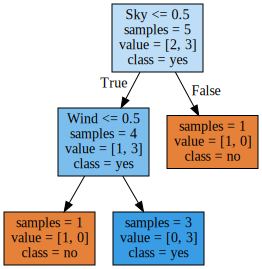

In [13]:
new_df = df.copy()
for col in new_df:
    for i, val in enumerate(set(new_df[col])):
        #print('{} = {} translated to {}'.format(col, val, i))
        new_df.loc[new_df[col] == val, col] = i

features = ['AirTemp','Forecast','Humidity','Sky','Water','Wind']
X = np.array(new_df[features], dtype=np.int)
y = np.array(new_df[['Date?']], dtype=np.int)

dc = DecisionTreeClassifier(criterion='entropy');
dc.fit(X, y);

export_graphviz(dc, out_file="tree.dot", class_names=["no", "yes"], 
                feature_names=features, impurity=False, filled=True);

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

Apparently, when multiple splits yield the same information gain, scikit choses a random one, whereas the version implemented above deterministically choses the first such split; after a few trials, it is possible to obtain the same decision tree. The other variables are Water and Wind, which in fact produce the same information gain, as reported during the construction of the tree above.

## Random Forests (4 points (1+1+2))
Study the effect of the number of trees in a RandomForest on the EEG-eye-state dataset (http://www.openml.org/d/1471). This dataset measures brain activity using 15 sensors, and you need to predict whether the person's eyes are open or closed. 

* Train a RandomForest classifier on this dataset with an increasing number of trees (on a log scale as above). Plot the Out-Of-Bag error against the number of trees.
    - The Out-Of-Bag error is the test error obtained when using bootstrapping, and using the non-drawn data points as the test set. This is what a RandomForest does internally, so you can retrieve it from the classifier. The code below hints on how to do this.
* Construct the same plot, but now use 10-fold Cross-validation and error rate instead of the OOB error. Compare the two. What do you learn from this?
* Compare the performance of the RandomForest ensemble with that of a single full decision tree. Compute the AUC as well as the bias and variance. Does the bias and variance increase/decrease for the ensemble? Does the number of trees affect the result?

Hint: Error rate = 1 - accuracy  
Hint: We discussed bias-variance decomposition in class. It is not included in scikit-learn, so you'll need to implement it yourself.

In [14]:
eeg = oml.datasets.get_dataset(1471) # Download Ionosphere data
X, y = eeg.get_data(target=eeg.default_target_attribute);

# shuffle data (not doing it causes problems with cross validation)
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]

### Solution

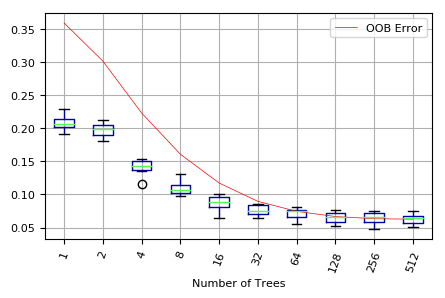

In [15]:
if DEBUG:
    print('*** DEBUG RUN ***')
    n_trees = [1, 10, 50]
else:
    n_trees = [2**i for i in range(10)]

scores_cv, scores_oob = [], []
for nt in n_trees:
    rfc = ensemble.RandomForestClassifier(
        n_estimators=nt, oob_score=True, n_jobs=-1
    );
    rfc.fit(X, y);
    scores_oob.append(1 - rfc.oob_score_);
    
    rfc = ensemble.RandomForestClassifier(n_estimators=nt);
    accuracies = cross_val_score(rfc, X, y, cv=10,
                                 n_jobs=-1, scoring='accuracy')
    scores_cv.append([1 - acc for acc in accuracies])

plt.xlabel('Number of Trees')
df = pd.DataFrame(scores_cv, index=n_trees);
df.T.boxplot(rot=70);
plt.plot(range(1, len(scores_oob) + 1), scores_oob, 'r-',
         label='OOB Error')
plt.legend(loc='best')
plt.show();

The OOB error tends to be higher than the 10-fold cross validation error, especially with few trees; as the number of trees grows, the two converge to the same value. It makes sense because, when computing the OOB error, the prediction for a sample is obtained from a smaller number of trees, which effectively correspond to evaluating a smaller random forest.

In [16]:
def compute_bias_variance(estimator, bootstraps, X, y):
    bias, variance = np.zeros(X.shape[0]), np.zeros(X.shape[0])
    split = ShuffleSplit(bootstraps, 0.33).split(X)
    for train_index, test_index in split:
        estimator.fit(X[train_index], y[train_index]);
        
        probs = rfc.predict_proba(X[test_index])[:, 1]
        bias[test_index] += ((probs > 0.5) != y[test_index])
        variance[test_index] += (1 - probs**2 + (1 - probs**2)) / 2
    return (bias**2 / bootstraps).sum(), variance.sum()

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, train_size=0.9, stratify=y
)

rfc = RandomForestClassifier(n_estimators=50, n_jobs=-1);
rfc.fit(Xtrain, ytrain);
auc_rf = roc_auc_score(ytest, rfc.predict_proba(Xtest)[:,1]);
bias_rf, var_rf = compute_bias_variance(rfc, 100, X, y);
print('Random Forest with 50 trees:')
print('\tAUC: {}\n\tBias: {}\n\tVariance: {}\n'.format(
    auc_rf, bias_rf, var_rf
))

dt = DecisionTreeClassifier();
dt.fit(Xtrain, ytrain);
auc_dt = roc_auc_score(ytest, dt.predict_proba(Xtest)[:,1]);
bias_dt, var_dt = compute_bias_variance(dt, 100, X, y);
print('Single Decision Tree:')
print('\tAUC: {}\n\tBias: {}\n\tVariance: {}\n'.format(
    auc_dt, bias_dt, var_dt
))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Random Forest with 50 trees:
	AUC: 0.9849551049233253
	Bias: 9146.609999999999
	Variance: 341540.75080000004



DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Single Decision Tree:
	AUC: 0.8383525020177562
	Bias: 4531.13
	Variance: 318056.7520000001



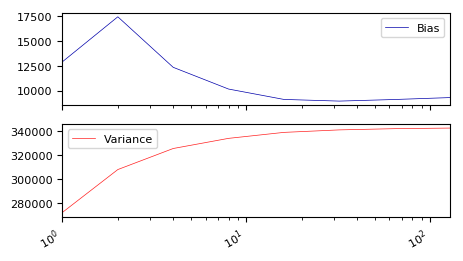

In [17]:
if DEBUG:
    print('*** DEBUG RUN ***')
    n_trees = [1, 10, 50]
    bootstraps = 10
else:
    n_trees = [2**i for i in range(8)]
    bootstraps = 100
    
biases, variances = [], []
for nt in n_trees:
    rfc = RandomForestClassifier(n_estimators=nt, n_jobs=-1);
    bias, var = compute_bias_variance(rfc, 100, X, y)
    biases.append(bias)
    variances.append(var)
    print('finished', nt, ' ' * 50, end='\r')
    
print(' ' * 100)
pd.DataFrame([biases, variances], index=['Bias', 'Variance'],
             columns=n_trees).T.plot(subplots=True, logx=True);

As expected, as the number of trees in the forest grows, bias decreases and variance increases, up to a certain point. They start to level off at around 30/50 trees, which is consistent with the plot shown above, where performances stabilize around the same number of trees.

## A regression benchmark (1 point)
Consider the liver-disorder dataset (http://www.openml.org/d/8). The goal is to predict how much alcohol someone consumed based on blood test values.

- Take a selection of the algorithms that we covered in class that can do regression.
- Based on what you learned in the previous exercises, make educated guesses about good hyperparameter values and set up a grid or random search.
- Evaluate all models with 10-fold cross-validation and root mean squared error (RMSE). Report all results. Which model yields the best results?

Scores for RandomForestRegressor:
	minimum: 1.973
	maximum: 5.978
	average: 3.273
Scores for Lasso:
	minimum: 1.538
	maximum: 6.116
	average: 3.172
Scores for Ridge:
	minimum: 1.538
	maximum: 6.116
	average: 3.172
Scores for LinearRegression:
	minimum: 1.538
	maximum: 6.116
	average: 3.172
Scores for GradientBoostingRegressor:
	minimum: 1.554
	maximum: 5.741
	average: 3.091


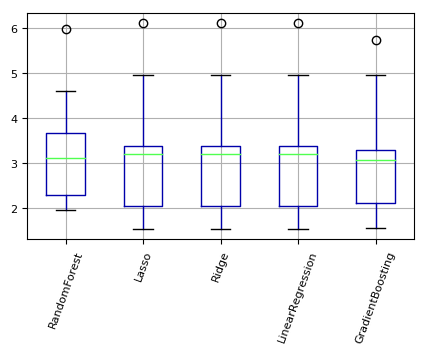

In [18]:
liver = oml.datasets.get_dataset(8) # Download Liver-disorders data
X, y = liver.get_data(target=liver.default_target_attribute);


n_iter = 10 if DEBUG else 1000
def score_model(model, param_distributions, n_iter=n_iter):
    if param_distributions:
        try:
            cv = RandomizedSearchCV(
                model, cv=10, n_jobs=-1, n_iter=n_iter,
                param_distributions=param_distributions,
                scoring='neg_mean_squared_error'
            );
            cv.fit(X, y);
        except ValueError:
            cv = GridSearchCV(
                model, cv=10, n_jobs=-1,
                param_grid=param_distributions,
                scoring='neg_mean_squared_error'
            );
            cv.fit(X, y);

        model = cv.best_estimator_

    scores = cross_val_score(model, X, y,
                             cv=10, scoring='neg_mean_squared_error');
    scores = np.sqrt(-scores)
    print('Scores for {}:\n\tminimum: {:.3f}\n\t'
          'maximum: {:.3f}\n\taverage: {:.3f}'.format(
        model.__class__.__name__, scores.min(),
        scores.max(), scores.mean()
    ))
    
    return scores


real_grid = [2**x for x in range(-20, 21)]

scores_rf = score_model(RandomForestRegressor(), {
    'n_estimators': [2**x for x in range(5, 11)]
});

scores_lasso = score_model(Lasso(), {
    'alpha': real_grid,
});

scores_ridge = score_model(Ridge(), {
    'alpha': real_grid
});

scores_lin = score_model(LinearRegression(), None)

scores_gb = score_model(GradientBoostingRegressor(), {
    'n_estimators': [2**x for x in range(5, 11)],
    'learning_rate': [2**x for x in range(-10, 1)],
    'subsample': [1.0 / x for x in range(1, 11)],
    'max_features': [1.0 / x for x in range(1, 11)],
})

cols = [
    'RandomForest', 'Lasso', 'Ridge',
    'LinearRegression', 'GradientBoosting'
]
df = pd.DataFrame([
    scores_rf, scores_lasso, scores_ridge, scores_lin, scores_gb
], index=cols);
axs = df.T.boxplot(cols);
plt.setp(axs.xaxis.get_majorticklabels(),
         rotation=70);

The five regressors achieve very similar RMSE, meaning that the target variable has a clear linear relationship with the predictor variables. The best performances were achieved by the three linear models, namely lasso, ridge and plain linear regression, even though the random forest regressor showed the least variability in the results. We are sure the relationship between the variables is linear, because linear model achieved the same performances as non-linear ones.

Due to its simplicity, yet top performances, we recommend the plain linear regression model.